In [32]:
!pip3 install lightgbm

You should consider upgrading via the '/home/michal/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from collections import Counter

In [2]:
train_data = pd.read_csv('./train.csv', index_col = 'Id')
test_data = pd.read_csv('./test.csv', index_col = 'Id')

print(train_data.shape)
train_data.groupby('Functional').count()
# tmp = train_data[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]]
# tmp.corr().abs()
# plt.figure(figsize=(100, 100))
# sb.heatmap(tmp.corr().abs(),  annot=True)
# plt.show()

(1460, 77)


MSSubClass  LotFrontage  LotArea  Street  LotShape  LandContour  \
Functional                                                                    
Maj1                14           12       14      14        14           14   
Maj2                 5            5        5       5         5            5   
Min1                31           24       31      31        31           31   
Min2                34           28       34      34        34           34   
Mod                 15           14       15      15        15           15   
Sev                  1            0        1       1         1            1   
Typ               1360         1118     1360    1360      1360         1360   

            Utilities  LotConfig  LandSlope  Neighborhood  ...  ScreenPorch  \
Functional                                                 ...                
Maj1               14         14         14            14  ...           14   
Maj2                5          5          5             5  ...            5   
Min1               31         31         31            31  ...           31   
Min2               34         34         34            34  ...           34   
Mod                15         15         15            15  ...           15   
Sev                 1          1          1             1  ...            1   
Typ              1360       1360       1360          1360  ...         1360   

            PoolArea  PoolQC  Fence  MiscVal  MoSold  YrSold  SaleType  \
Functional                                                               
Maj1              14       0      4       14      14      14        14   
Maj2               5       0      0        5       5       5         5   
Min1              31       0     16       31      31      31        31   
Min2              34       0      8       34      34      34        34   
Mod               15       0      3       15      15      15        15   
Sev                1       0      0        1       1       1         1   
Typ             1360       7    250     1360    1360    1360      1360   

            SaleCondition  SalePrice  
Functional                            
Maj1                   14         14  
Maj2                    5          5  
Min1                   31         31  
Min2                   34         34  
Mod                    15         15  
Sev                     1          1  
Typ                  1360       1360  

[7 rows x 76 columns]

# Plan
1. empty values/NaNs  - we can think about imputation or smarter way to drop samples
2. check for outliers
3. see distributions for features
4. remove features that has small variability   - 
5. mapping classes into numeric values
6. look into feature correlation

**1**

In [3]:
#train_data
def factorize_categorical(df):
    df_copy = df.copy() 
    mapping_map = {
        "LotShape": {"Reg":1, "IR1":2/3 , "IR2":1/3, "IR3":0},
        "LandContour": {"Lvl":1 , "Bnk":2/3 , "HLS":1/3, "Low":0},
        "LotConfig": {"Inside":1, "Corner":0.75, "CulDSac":0.5, "FR2":0.25, "FR3":0},
        "LandSlope": {"Gtl":1, "Mod":0.5,  "Sev":0},
        "BldgType": {"1Fam":1, "2FmCon":0.75, "Duplx":0.5, "TwnhsE":0.25, "TwnhsI":0},
        "ExterQual": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "ExterCond": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "BsmtQual": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "BsmtCond": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "BsmtExposure": {"Gd":1, "Av":0.75, "Mn":0.5, "No":0.25, "NA":0},
        "BsmtFinType1": {"GLQ":1, "ALQ":5/6, "BLQ":4/6, "Rec":3/6, "LwQ":2/6, "Unf":1/6, "NA":0},
        "BsmtFinType2": {"GLQ":1, "ALQ":5/6, "BLQ":4/6, "Rec":3/6, "LwQ":2/6, "Unf":1/6, "NA":0},
        "HeatingQC": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "KitchenQual": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "Functional": {"Typ":1, "Min1":6/7, "Min2":5/7, "Mod":4/7, "Maj1":3/7, "Maj2":2/7, "Sev":1/7, "Sal":0},
        "FireplaceQu": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "GarageFinish": {"Fin":1, "RFn":2/3, "Unf": 1/3, "NA":0},
        "GarageQual": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "GarageCond": {"Ex":1, "Gd":0.8, "TA":0.6, "Fa":0.4, "Po":0.2, "NA":0},
        "PavedDrive": {"Y":1, "P":0.5, "N":0},
        "PoolQC": {"Ex":1, "Gd":0.75, "TA":0.5, "Fa":0.25, "Po":0},
        "Fence": {"GdPrv":1, "MnPrv":0.75, "GdWo":0.5, "MnWw":0.25, "NA":0},
        "SaleCondition": {"Normal":1, "Abnorml":0.75, "Alloca":0.5, "Family":0.25, "Partial":0}
    }
    
    for key, value in mapping_map.items():
        df_copy[key] = df_copy[key].map(value)
        
    return df_copy

In [22]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 20):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_rid_of_high_related_columns(df):
    print("Shape before cleaning:", df.shape[1])
    df_copy = df.copy()
    high_impact_on_price = []

    columns_to_drop = []
    
    top_abs = get_top_abs_correlations(df_copy)

    for ind in top_abs.index:
        if 'SalePrice' in ind:
            high_impact_on_price.append(ind[0])

    for i, k in zip(top_abs.index, top_abs):
        if (i[0] in high_impact_on_price) or (i[1] in high_impact_on_price):
            continue

        if k > 0.75:
            columns_to_drop.append(i[0])
    
    df = df.drop(columns = columns_to_drop)
    
    return df, columns_to_drop

def fill_na_with_meaning(df):
    columns_with_na = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond" , "PoolQC", "Fence"]
    for col in columns_with_na:
        df[col] = df[col].fillna(0)
    return df

def clean_garages(df):
    # Amount of NaN values in the remaining object columns
    # 'Exterior1st' - 1
    # 'Exterior2nd' - 1 
    # 'SaleType' - 1
    # 'Utilities' - 2
    # 'MasVnrType' - 16
    # 'GarageType' - 76
    
    # We found that GarageType is biggest source of NaNs in test set,
    # so we decided to clean it up manually by looking up in already factorized colums 
    # that relates to GarageType - GarageCond/GarageQlt
    df['GarageType'] = df['GarageType'].fillna(0)
    return df

def factorization_mapping(df):
    train_factor_mapping = {}

    # For columns that are still of type object we are factorizing
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col], uniques = pd.factorize(df[col], sort = True)
            train_factor_mapping[col] = dict(zip(uniques.to_list(), range(len(uniques))))
            
    return df, train_factor_mapping

def apply_factor_map_to_test(df, factor_map):
    for col in factor_map:
        df[col] = df[col].map(factor_map[col])
        df[col] = df[col].fillna(-1)

    return df

def categories_to_dummies(df, factor_map):
    for col in factor_map:
        if len(factor_map[col])>2:
            print("column to dummies-", col)
            dummies = pd.get_dummies(df[col])
            df = df.drop(columns=[col])
            df = pd.concat([df, dummies], axis=1)
    return df

def remove_outliers(df, z_score = 5):
    print(df.shape, "before zscore")
    # remove outliers by there Z-score (example" LotArea column)
    # The recommended threshold is 3, but it cuased a big number of drops so I increased it to 5 
    df = df[(np.abs(zscore(df)) < z_score).all(axis=1)]
    print(df.shape, "after zscore")
    
    return df

def low_variance_columns(df, percentage = 0.99):
    # detect columns with high precantage from one value
    low_variance_col = []
    
    for col in df.columns:
        count= df[col].value_counts(normalize=True).values
        if sum(count>percentage):
            low_variance_col.append(col)
    
    df = df.drop(columns = low_variance_col)
    
    return df, low_variance_col

def apply_low_variance_to_test(df, low_variance_col):
    df = df.drop(columns = low_variance_col)
    return df

def clean_train(df):
    df = df.copy()

    # Columns where NaN means that something doesn't exists rather that it's an empty data or unknown
    df = fill_na_with_meaning(df)
    
    # Map categorical values where categories represent weights
    df = factorize_categorical(df)
    
    df = clean_garages(df)
    
    # NOTA BENE: only for train set
    df, factor_map = factorization_mapping(df)
    
    # fillna with mean col value
    df = df.fillna(df.mean())
    
    # NOTA BENE: only for train set
    df = remove_outliers(df)
    
    # NOTA BENE: only for train set
    df, low_variance_col = low_variance_columns(df)
    
    # NOTA BENE: only for train set
    df, columns_to_drop = get_rid_of_high_related_columns(df)
    
    return df, factor_map, low_variance_col, columns_to_drop

def clean_test(df, factor_map, low_variance_col, columns_to_drop):    
    df = df.copy()

    # Columns where NaN means that something doesn't exists rather that it's an empty data or unknown
    df = fill_na_with_meaning(df)
    
    # Map categorical values where categories represent weights
    df = factorize_categorical(df)
    
    df = clean_garages(df)
    
    # NOTA BENE: only for test set
    df = apply_factor_map_to_test(df, factor_map)
    
    # fillna with mean col value
    df = df.fillna(df.mean())
    
    # NOTA BENE: only for test set
    df = apply_low_variance_to_test(df, low_variance_col)
    
    # NOTA BENE: only for test set
    df = df.drop(columns = columns_to_drop)
    
    return df


In [23]:
def data_dist(df):
    n_col = 6
    n_row = np.ceil(df.shape[1]/n_col)
    fig = plt.figure(figsize=(3 * n_col, 2.4 * n_row))  
    for i, col in enumerate(df.columns):
        plt.subplot(n_row, n_col, i + 1)
        n, bins, patches= plt.hist(df[col], density=True)
        plt.title(col, y=1.03)
    fig.tight_layout(pad=2)

(1460, 77) before zscore
(1280, 77) after zscore
Shape before cleaning: 69
Trainining data distribution


<ipython-input-23-4054fa8dea82>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_row, n_col, i + 1)


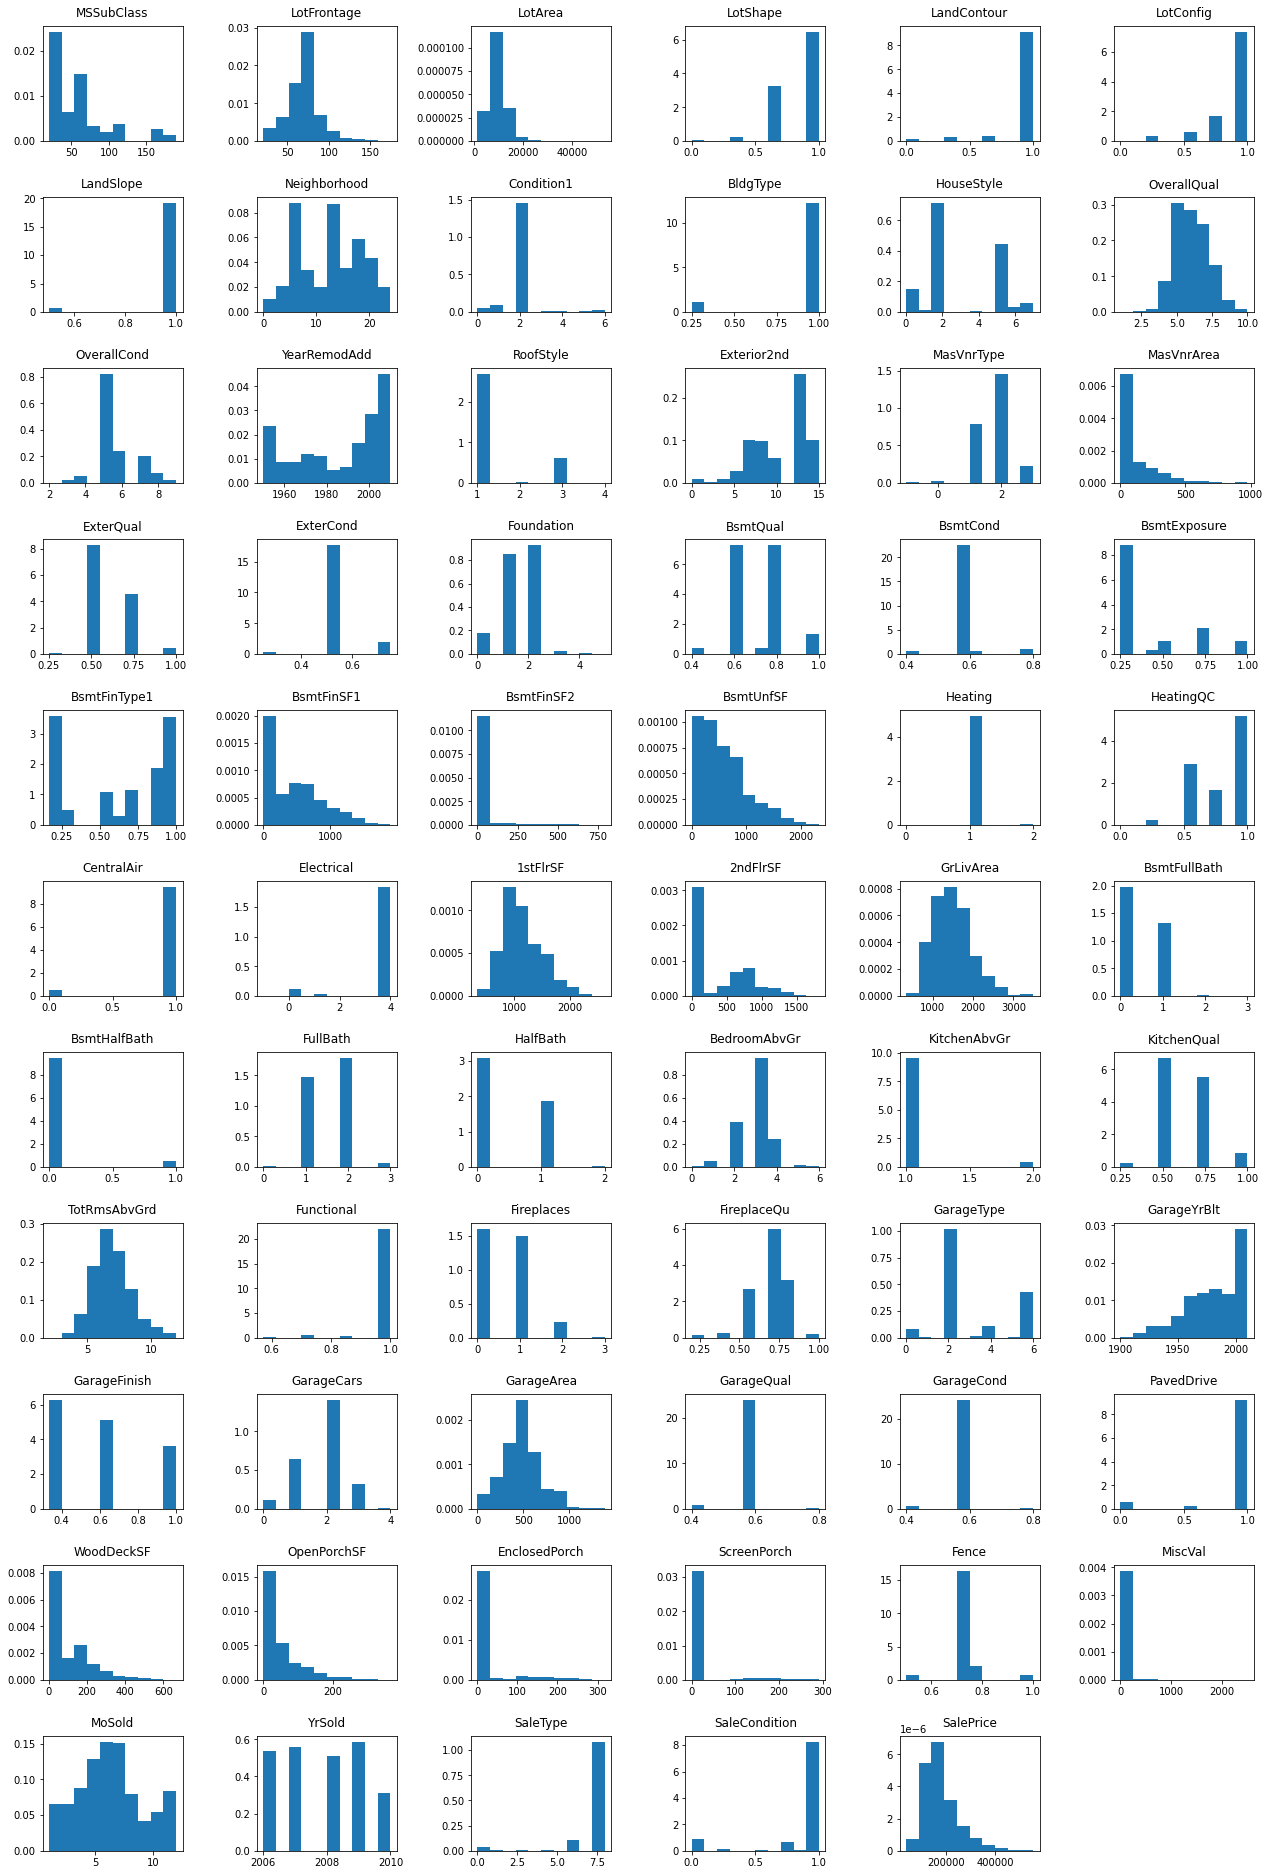

In [24]:
train, factor_map, low_variance_col, columns_to_drop = clean_train(train_data)
print("Trainining data distribution")
data_dist(train)

# one issue we didnt handle is to transfer all categoriacl columns into dummies. we should do it based on 
#  "factor_map" and better to do that at the end of the process. 
# I wrote a function that is doinf that - categories_to_dummies- but it will be better to consider in 
# here that "Condition1" + "Condition2" & "Exterior1st" + "Exterior2nd" will get dummies together
# **there mapping dict is different so I wasnt sure how to do that

# column to dummies- Condition1  #can be together with next one
# column to dummies- Condition2

# column to dummies- Exterior1st  #can be together with next one
# column to dummies- Exterior2nd


In [25]:
train.head()

MSSubClass  LotFrontage  LotArea  LotShape  LandContour  LotConfig  \
Id                                                                       
1           60         65.0     8450  1.000000          1.0       1.00   
2           20         80.0     9600  1.000000          1.0       0.25   
3           60         68.0    11250  0.666667          1.0       1.00   
4           70         60.0     9550  0.666667          1.0       0.75   
5           60         84.0    14260  0.666667          1.0       0.25   

    LandSlope  Neighborhood  Condition1  BldgType  ...  OpenPorchSF  \
Id                                                 ...                
1         1.0             5           2       1.0  ...           61   
2         1.0            24           1       1.0  ...            0   
3         1.0             5           2       1.0  ...           42   
4         1.0             6           2       1.0  ...           35   
5         1.0            15           2       1.0  ...           84   

    EnclosedPorch  ScreenPorch     Fence  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                            
1               0            0  0.734875        0       2    2008         8   
2               0            0  0.734875        0       5    2007         8   
3               0            0  0.734875        0       9    2008         8   
4             272            0  0.734875        0       2    2006         8   
5               0            0  0.734875        0      12    2008         8   

    SaleCondition  SalePrice  
Id                            
1            1.00     208500  
2            1.00     181500  
3            1.00     223500  
4            0.75     140000  
5            1.00     250000  

[5 rows x 65 columns]

In [45]:
plt.figure(figsize=(200, 200), dpi=100)
sb.heatmap(train.corr().abs(),  annot=True)
plt.show()

Test data distribution


<ipython-input-5-4054fa8dea82>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_row, n_col, i + 1)


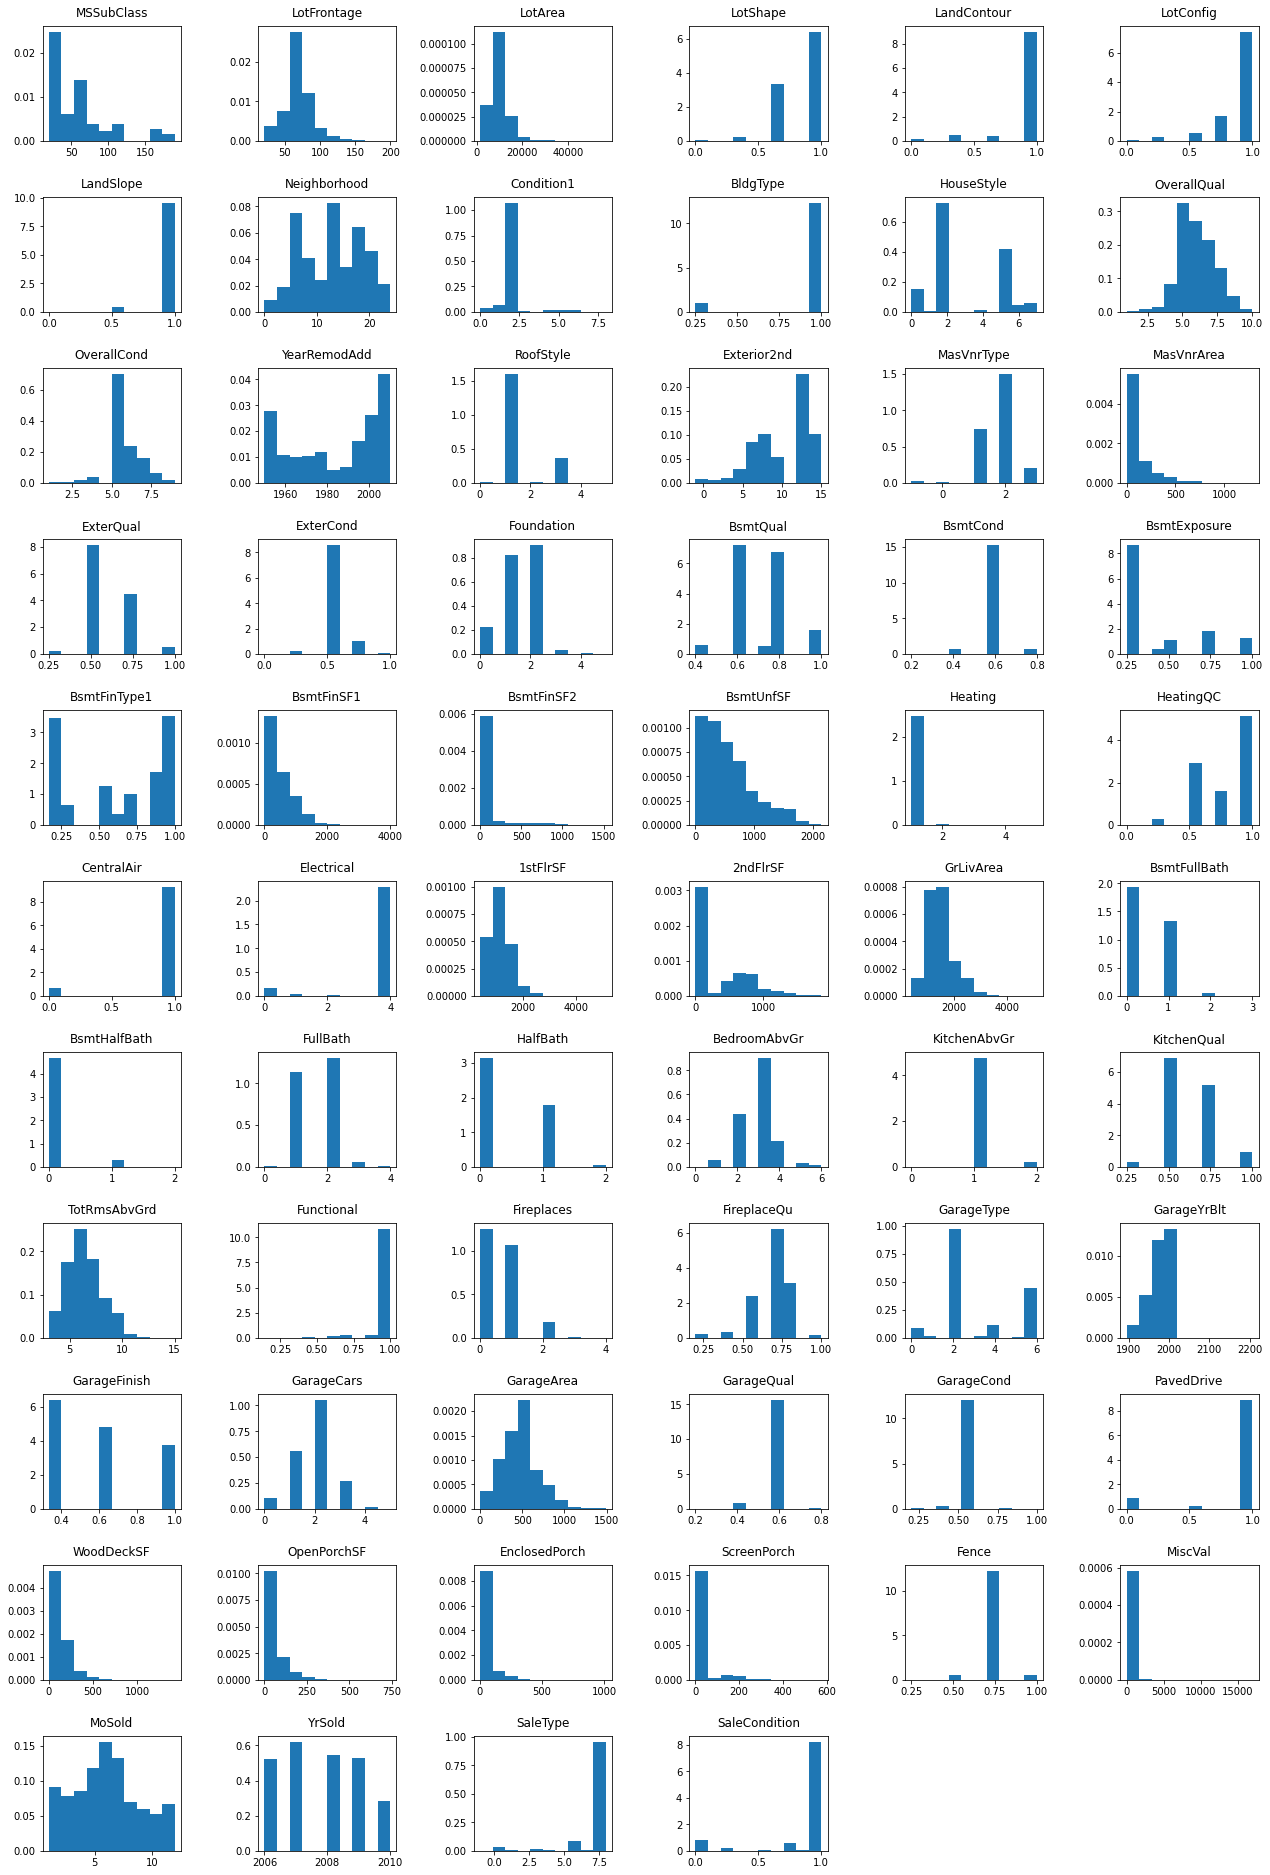

In [7]:
test = clean_test(test_data, factor_map, low_variance_col, columns_to_drop)

print("Test data distribution")
data_dist(test)


In [63]:
# basically I want to clean outliers and find 
# col; where most samples have the same values




In [11]:
train.head(20)

MSSubClass  LotFrontage  LotArea  LotShape  LandContour  LotConfig  \
Id                                                                       
1           60    65.000000     8450  1.000000     1.000000       1.00   
2           20    80.000000     9600  1.000000     1.000000       0.25   
3           60    68.000000    11250  0.666667     1.000000       1.00   
4           70    60.000000     9550  0.666667     1.000000       0.75   
5           60    84.000000    14260  0.666667     1.000000       0.25   
7           20    75.000000    10084  1.000000     1.000000       1.00   
8           60    70.049958    10382  0.666667     1.000000       0.75   
9           50    51.000000     6120  1.000000     1.000000       1.00   
11          20    70.000000    11200  1.000000     1.000000       1.00   
12          60    85.000000    11924  0.666667     1.000000       1.00   
13          20    70.049958    12968  0.333333     1.000000       1.00   
14          20    91.000000    10652  0.666667     1.000000       1.00   
15          20    70.049958    10920  0.666667     1.000000       0.75   
16          45    51.000000     6120  1.000000     1.000000       0.75   
17          20    70.049958    11241  0.666667     1.000000       0.50   
18          90    72.000000    10791  1.000000     1.000000       1.00   
19          20    66.000000    13695  1.000000     1.000000       1.00   
20          20    70.000000     7560  1.000000     1.000000       1.00   
21          60   101.000000    14215  0.666667     1.000000       0.75   
22          45    57.000000     7449  1.000000     0.666667       1.00   

    LandSlope  Neighborhood  Condition1  BldgType  ...  OpenPorchSF  \
Id                                                 ...                
1         1.0             5           2  1.000000  ...           61   
2         1.0            24           1  1.000000  ...            0   
3         1.0             5           2  1.000000  ...           42   
4         1.0             6           2  1.000000  ...           35   
5         1.0            15           2  1.000000  ...           84   
7         1.0            21           2  1.000000  ...           57   
8         1.0            14           4  1.000000  ...          204   
9         1.0            17           0  1.000000  ...            0   
11        1.0            19           2  1.000000  ...            0   
12        1.0            16           2  1.000000  ...           21   
13        1.0            19           2  1.000000  ...            0   
14        1.0             5           2  1.000000  ...           33   
15        1.0            12           2  1.000000  ...          213   
16        1.0             3           2  1.000000  ...          112   
17        1.0            12           2  1.000000  ...            0   
18        1.0            19           2  0.935907  ...            0   
19        1.0            20           5  1.000000  ...          102   
20        1.0            12           2  1.000000  ...            0   
21        1.0            16           2  1.000000  ...          154   
22        1.0             9           2  1.000000  ...            0   

    EnclosedPorch  ScreenPorch     Fence  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                            
1               0            0  0.734875        0       2    2008         8   
2               0            0  0.734875        0       5    2007         8   
3               0            0  0.734875        0       9    2008         8   
4             272            0  0.734875        0       2    2006         8   
5               0            0  0.734875        0      12    2008         8   
7               0            0  0.734875        0       8    2007         8   
8             228            0  0.734875      350      11    2009         8   
9             205            0  0.734875        0       4    2008         8   
11              0     

**Building a model**

steps:
1. Split training set to train and validation-  we evaluate our model based on training set only 
2. Try few types of models and evaluate there "basic" performence
3. Go with the best 1-2 models types and do Hyper-params tuning based on the validation set
4. Evaluate models- develop matricws that can tell about the performence for that specific task- like confusion matrix for defined price classes

Questions/wonders I have-
1. We do not have the test labels- so should we evaluate our performence based on the validation set? Or do we want aslo to keep a " labeled test set" on the side?



In [27]:
train.head()

MSSubClass  LotFrontage  LotArea  LotShape  LandContour  LotConfig  \
Id                                                                       
1           60         65.0     8450  1.000000          1.0       1.00   
2           20         80.0     9600  1.000000          1.0       0.25   
3           60         68.0    11250  0.666667          1.0       1.00   
4           70         60.0     9550  0.666667          1.0       0.75   
5           60         84.0    14260  0.666667          1.0       0.25   

    LandSlope  Neighborhood  Condition1  BldgType  ...  OpenPorchSF  \
Id                                                 ...                
1         1.0             5           2       1.0  ...           61   
2         1.0            24           1       1.0  ...            0   
3         1.0             5           2       1.0  ...           42   
4         1.0             6           2       1.0  ...           35   
5         1.0            15           2       1.0  ...           84   

    EnclosedPorch  ScreenPorch     Fence  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                            
1               0            0  0.734875        0       2    2008         8   
2               0            0  0.734875        0       5    2007         8   
3               0            0  0.734875        0       9    2008         8   
4             272            0  0.734875        0       2    2006         8   
5               0            0  0.734875        0      12    2008         8   

    SaleCondition  SalePrice  
Id                            
1            1.00     208500  
2            1.00     181500  
3            1.00     223500  
4            0.75     140000  
5            1.00     250000  

[5 rows x 65 columns]

In [29]:
#Train-test split

from sklearn.model_selection import train_test_split

y = train.SalePrice
X = train.drop(columns=["SalePrice"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)  #split and keep similar y dist.

In [34]:
# Models we want to "test":
from sklearn.metrics import mean_absolute_error
# Linear Regression
from sklearn.linear_model import LinearRegression

# LGBM Regressor
from lightgbm import LGBMRegressor

# XGBoost Regressor
from xgboost.sklearn import XGBRegressor

# CatBoost Regressor
from catboost import CatBoostRegressor

# Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor

# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge

# Elastic Net Regression
from sklearn.linear_model import ElasticNet

# Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge

# Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

LinearRegression model MAE= 16397.328633388126
LGBMRegressor model MAE= 14282.342524561895
XGBRegressor model MAE= 15461.589060465494
CatBoostRegressor model MAE= 13490.705269522863
KernelRidge model MAE= 16203.768040974936
ElasticNet model MAE= 17737.534213971074


/home/michal/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345638608869.35583, tolerance: 475455295.7539553
  model = cd_fast.enet_coordinate_descent(


BayesianRidge model MAE= 16259.864084695815
GradientBoostingRegressor model MAE= 14846.623939841491
SVR model MAE= 54366.4465952061


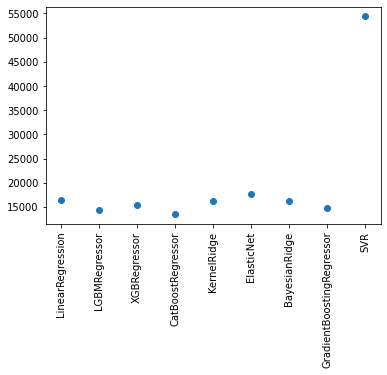

In [44]:
models= [LinearRegression(), LGBMRegressor(), XGBRegressor(), CatBoostRegressor(logging_level='Silent'), KernelRidge(), ElasticNet(), BayesianRidge(), GradientBoostingRegressor(), SVR()]
m_names= ["LinearRegression", "LGBMRegressor", "XGBRegressor", "CatBoostRegressor", "KernelRidge", "ElasticNet", "BayesianRidge", "GradientBoostingRegressor", "SVR"]

performance=[]
for model, name in zip(models, m_names):
    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    mae= mean_absolute_error(y_pred, y_val)
    performance.append(mae)
    print(f"{name} model MAE= {mae}")
    
plt.plot(m_names, performance, "o")
plt.xticks(rotation=90)
plt.show()

In [39]:
performance

[16397.328633388126,
 14282.342524561895,
 15461.589060465494,
 13490.705269522863,
 2.705514268454254e+16,
 16203.768040974936,
 17737.534213971074,
 16259.864084695815,
 14945.438625355395,
 54366.4465952061]